In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.prune as prune
import seaborn as sns

import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.cuda.amp import autocast, GradScaler

import pandas as pd
from torch import nn, optim

from sklearn.metrics import confusion_matrix

In [2]:
from ConvNet import ConvNet
from DatasetEcg import DatasetECG

In [3]:
train_pth = 'sh_dataset\\train\\'

val_pth = 'sh_dataset\\validation\\'

model_name = 'model'

DIR = 'models\\main_model_unst_pr_l1\\'

MODEL_PATH = 'models\\main_model\\model21.pth'

batch_size = 16

train_ds_ecg = DatasetECG(train_pth)
val_ds_ecg = DatasetECG(val_pth)

train_loader = torch.utils.data.DataLoader(
    train_ds_ecg, shuffle=True, 
    batch_size=batch_size, drop_last=True
)

val_loader = torch.utils.data.DataLoader(
    val_ds_ecg, shuffle=True,
    batch_size=batch_size, drop_last=True
)

7500
1250


In [4]:
model = torch.load(MODEL_PATH)
model

ConvNet(
  (act): ReLU()
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv1): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (linear0): Linear(in_features=15488, out_features=512, bias=True)
  (linear1): Linear(in_features=512, out_features=128, bias=True)
  (linear2): Linear(in_features=128, out_features=5, bias=True)
)

In [5]:
spars_lst = [0.1, 0.2, 0.3, 0.4, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.9, 0.95]

In [6]:
acc_list = []

In [7]:
device = 'cuda'

In [8]:
for sp in spars_lst:
    model = torch.load(MODEL_PATH)
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount=sp)
        elif isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=sp)

    correct=0
    total=0

    with torch.no_grad():
        for data in val_loader:
            images,labels=data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)

            outputs=model(images)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accu=100.*correct/total
    acc_list.append(accu)
    
    #print(dict(new_model.named_buffers()).keys()) 

In [9]:
np.save(DIR + model_name + '_pr_acc', acc_list)

In [14]:
def train(epoch):
  print('\nEpoch : %d'%epoch)
  
  model.train()

  running_loss=0
  correct=0
  total=0

  for data in tqdm(train_loader):
    inputs = data[0].to(device, non_blocking=True)
    labels=data[1].to(device, non_blocking=True)

    outputs=model(inputs)

    loss=loss_fn(outputs,labels)

    #Replaces pow(2.0) with abs() for L1 regularization

    l2_lambda = 0.001
    l2_norm = sum(p.pow(2.0).sum()
                  for p in model.parameters())

    loss = loss + l2_lambda * l2_norm

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()

      
  train_loss=running_loss/len(train_loader)
  accu=100.*correct/total

  train_accu.append(accu)
  train_losses.append(train_loss)

In [15]:
def test(epoch):
  model.eval()

  running_loss=0
  correct=0
  total=0

  with torch.no_grad():

    for data in tqdm(val_loader):
      images,labels=data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)

      outputs=model(images)

      loss= loss_fn(outputs,labels)
      running_loss+=loss.item()

      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()


  test_loss=running_loss/len(val_loader)
  accu=100.*correct/total
  
  eval_losses.append(test_loss)
  eval_accu.append(accu)

In [16]:
ft_acc_list = []
eval_accu = []


In [ ]:
for sp in spars_lst[3:]:
    model = torch.load(MODEL_PATH)
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d):
            prune.l1_unstructured(module, name='weight', amount= sp)
        elif isinstance(module, torch.nn.Linear):
            prune.l1_unstructured(module, name='weight', amount= sp)
            
    train_losses=[]
    train_accu=[]

    eval_losses=[]
    eval_accu=[]
    max_accuracy = 0
    loss_fn=nn.CrossEntropyLoss()
    optimizer=optim.SGD(model.parameters(),lr=0.001,momentum=0.9)

    epochs = 1
    
    device = 'cuda'
    model = model.to(device)
    loss_fn = loss_fn.to(device)
    
    use_amp = True
    scaler = torch.cuda.amp.GradScaler()
    torch.backends.cudnn.benchmark = True
    torch.backends.cudnn.deterministic = False
    
    for epoch in range(1,epochs+1): 
      MOD_PTH = DIR + 'ft_' + model_name + str(int(sp*100)) + '_' + str(epoch) + '.pth'
      D_MOD_PTH = DIR + 'd_ft_' + model_name + str(int(sp*100)) + '_' + str(epoch) + '.pth'
      train(epoch)
      test(epoch)
      acc_ep = eval_accu[-1]

      if acc_ep > max_accuracy:
        max_accuracy = acc_ep    
        torch.save(model, MOD_PTH)
        torch.save(model.state_dict(), D_MOD_PTH)

    ft_acc_list.append(max_accuracy)


    correct=0
    total=0

    with torch.no_grad():
        for data in val_loader:
            images,labels=data[0].to(device, non_blocking=True),data[1].to(device, non_blocking=True)

            outputs=model(images)

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    accu=100.*correct/total
    acc_list1.append(accu)

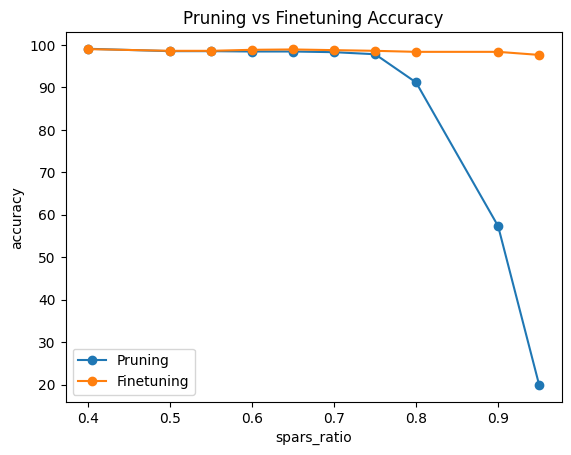

In [18]:
plt.plot(spars_lst[3:], acc_list[3:],'-o')
plt.plot(spars_lst[3:], ft_acc_list,'-o')
plt.xlabel('spars_ratio')
plt.ylabel('accuracy')
plt.legend(['Pruning','Finetuning'])
plt.title('Pruning vs Finetuning Accuracy')

plt.show()

In [19]:
ft_acc_list

[98.95833333333333,
 98.5576923076923,
 98.5576923076923,
 98.79807692307692,
 98.87820512820512,
 98.71794871794872,
 98.5576923076923,
 98.3173076923077,
 98.3173076923077,
 97.59615384615384]